In [ ]:
from pathlib import Path


repo_dir = Path("Depth-Anything-V2")

if not repo_dir.exists():
    !git clone https://huggingface.co/spaces/depth-anything/Depth-Anything-V2
%cd Depth-Anything-V2

/content/Depth-Anything-V2


In [ ]:
import platform

%pip install -q "openvino>=2024.2.0" "datasets>=2.14.6" "nncf>=2.11.0" "tqdm" "matplotlib>=3.4"
%pip install -q "typing-extensions>=4.9.0" eval-type-backport "gradio>=4.19"
%pip install -q -r requirements.txt --extra-index-url https://download.pytorch.org/whl/cpu

if platform.python_version_tuple()[1] in ["8", "9"]:
    %pip install -q "gradio-imageslider<=0.0.17" "typing-extensions>=4.9.0"

In [ ]:
attention_file_path = Path("./depth_anything_v2/dinov2_layers/attention.py")
orig_attention_path = attention_file_path.parent / ("orig_" + attention_file_path.name)

if not orig_attention_path.exists():
    attention_file_path.rename(orig_attention_path)

    with orig_attention_path.open("r") as f:
        data = f.read()
        data = data.replace("XFORMERS_AVAILABLE = True", "XFORMERS_AVAILABLE = False")
        with attention_file_path.open("w") as out_f:
            out_f.write(data)

In [ ]:
#get image from nuscenes

!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2024-10-22 22:08:56--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 13.224.14.23, 13.224.14.105, 13.224.14.15, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|13.224.14.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz.1’

v1.0-mini.tgz.1     100%[===================>]   3.88G  71.5MB/s    in 51s     

2024-10-22 22:09:47 (78.4 MB/s) - ‘v1.0-mini.tgz.1’ saved [4167696325/4167696325]



In [ ]:
!pip install open3d

In [ ]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud
import matplotlib.pyplot as plt
import cv2

# Load the NuScenes dataset
nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

# Choose a sample (example using the first scene and first sample)
scene = nusc.scene[0]
first_sample_token = scene['first_sample_token']
sample = nusc.get('sample', first_sample_token)

# Get the front camera data from the sample
cam_front_data = sample['data']['CAM_FRONT']

# Load the image metadata
cam_front = nusc.get('sample_data', cam_front_data)

# Load the image file
image_path = nusc.get_sample_data_path(cam_front_data)
img = cv2.imread(image_path)

#choosing other samples

# Choose a sample (example using the first scene and first sample)
scene2 = nusc.scene[3]
first_sample_token2 = scene['first_sample_token']
sample2 = nusc.get('sample', first_sample_token2)

# Get the front camera data from the sample
cam_front_data2 = sample['data']['CAM_BACK']

# Load the image metadata
cam_front2 = nusc.get('sample_data', cam_front_data2)

# Load the image file
image_path2 = nusc.get_sample_data_path(cam_front_data2)
img2 = cv2.imread(image_path2)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.892 seconds.
Reverse indexing ...
Done reverse indexing in 0.3 seconds.


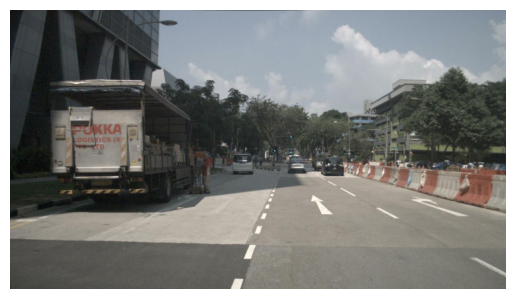

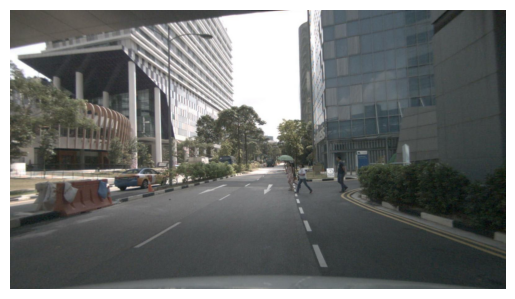

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
from huggingface_hub import hf_hub_download

encoder = "vits"
model_type = "Small"
model_id = f"depth_anything_v2_{encoder}"

model_path = hf_hub_download(repo_id=f"depth-anything/Depth-Anything-V2-{model_type}", filename=f"{model_id}.pth", repo_type="model")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
import torch.nn.functional as F

from depth_anything_v2.dpt import DepthAnythingV2

model = DepthAnythingV2(encoder=encoder, features=64, out_channels=[48, 96, 192, 384])
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

raw_img = img
image, (h, w) = model.image2tensor(raw_img)
image = image.to("cpu").to(torch.float32)

with torch.no_grad():
    depth = model.forward(image)

depth = F.interpolate(depth[:, None], (h, w), mode="bilinear", align_corners=True)[0, 0]

output = depth.cpu().numpy()

<ipython-input-9-e9f7477e1d53>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cpu"))


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2


def get_depth_map(output, w, h):
    depth = cv2.resize(output, (w, h))

    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)

    depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

    return depth

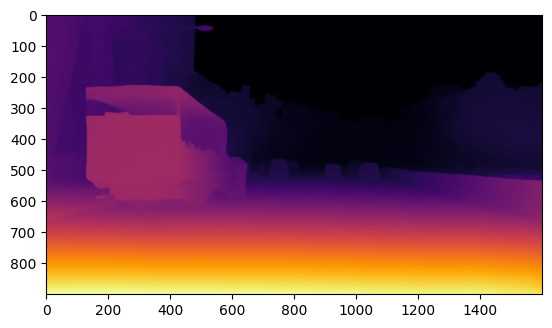

In [ ]:
h, w = raw_img.shape[:-1]
res_depth = get_depth_map(output, w, h)
plt.imshow(res_depth[:, :, ::-1])

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

[10/22 22:11:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([2, 2, 7, 2, 2, 0, 2, 2, 9, 2], device='cuda:0')
Boxes(tensor([[1002.1948,  474.8147, 1077.8014,  536.7258],
        [ 896.9116,  479.2071,  957.6199,  526.8022],
        [ 125.2271,  160.4897,  617.5515,  613.1305],
        [1361.1036,  484.8504, 1423.1603,  515.1666],
        [ 717.0093,  461.3268,  785.2176,  529.3829],
        [ 803.1168,  472.0064,  816.5465,  508.9730],
        [ 899.1501,  471.6318,  948.7336,  496.7751],
        [ 975.9593,  462.1656, 1029.8182,  515.2678],
        [ 849.1218,  447.6624,  859.1573,  458.9096],
        [1307.7889,  484.7197, 1352.8793,  510.9044]], device='cuda:0'))


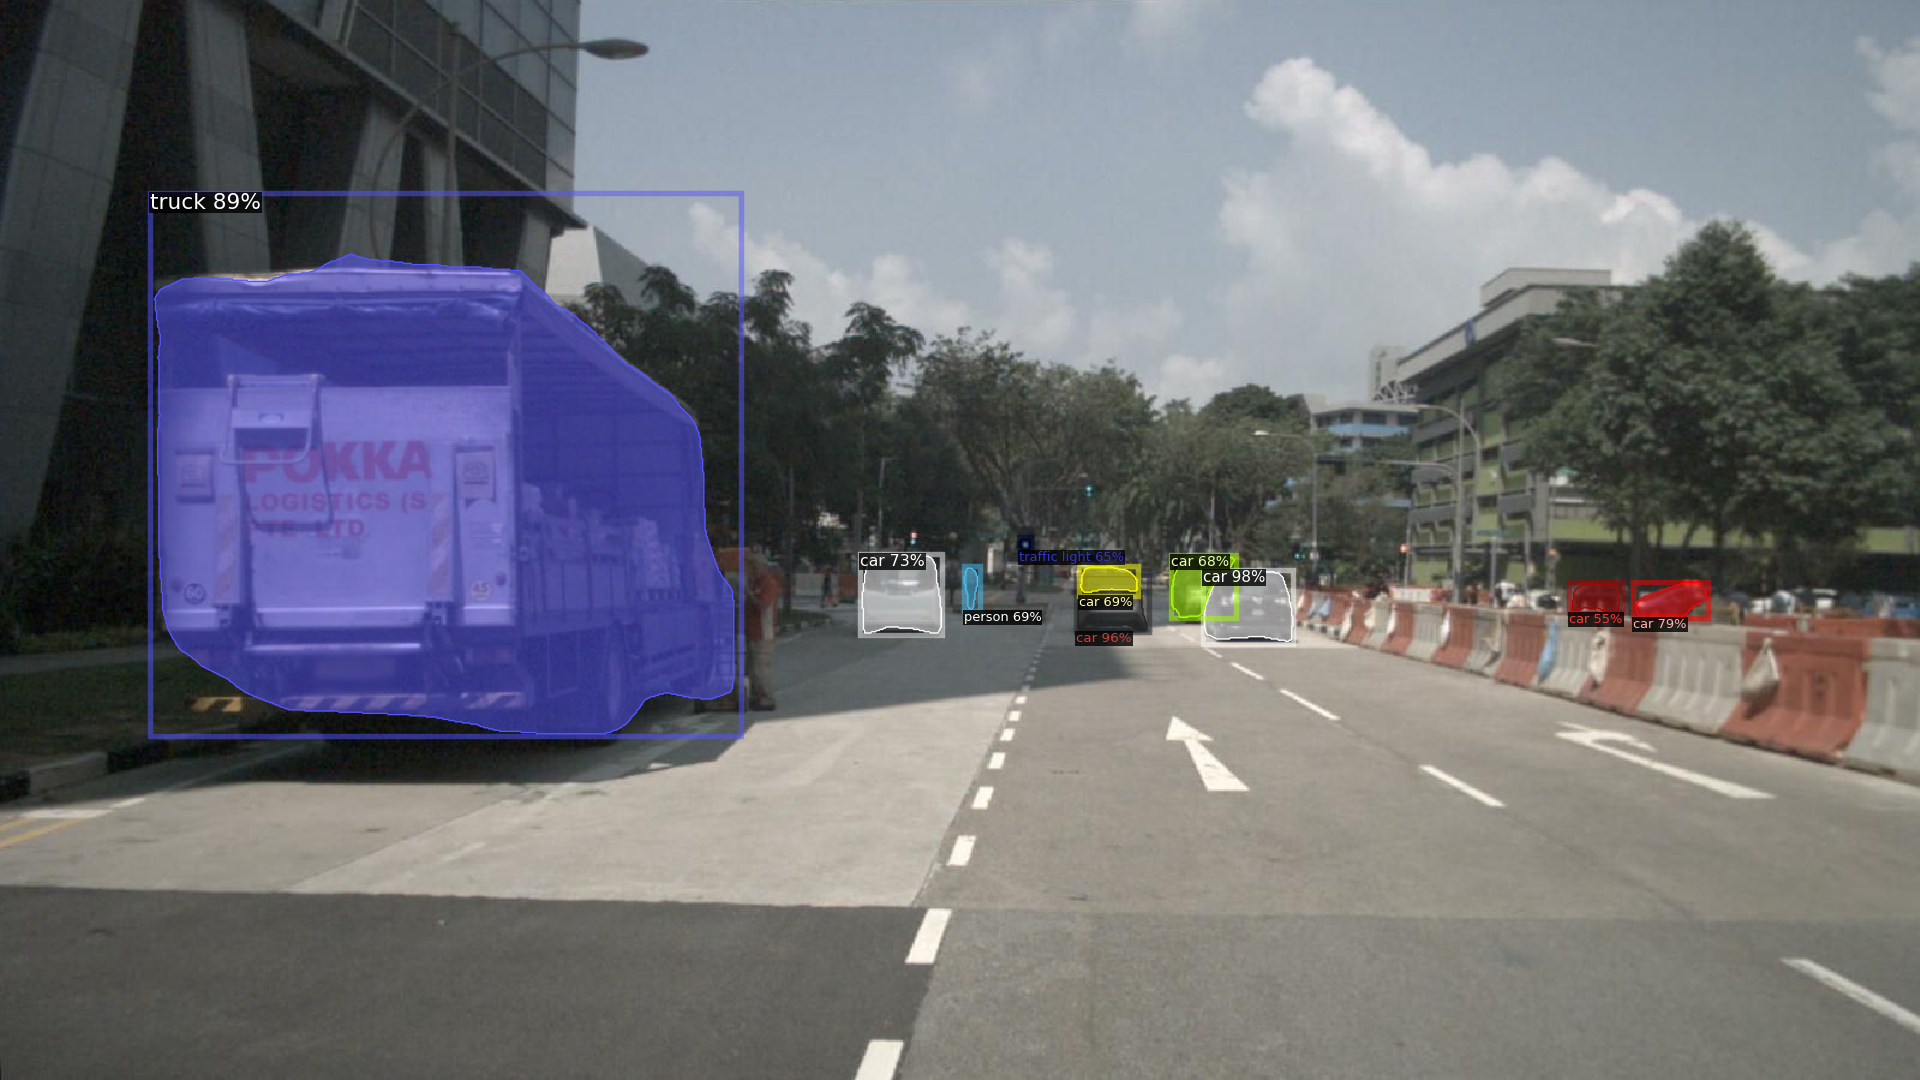

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

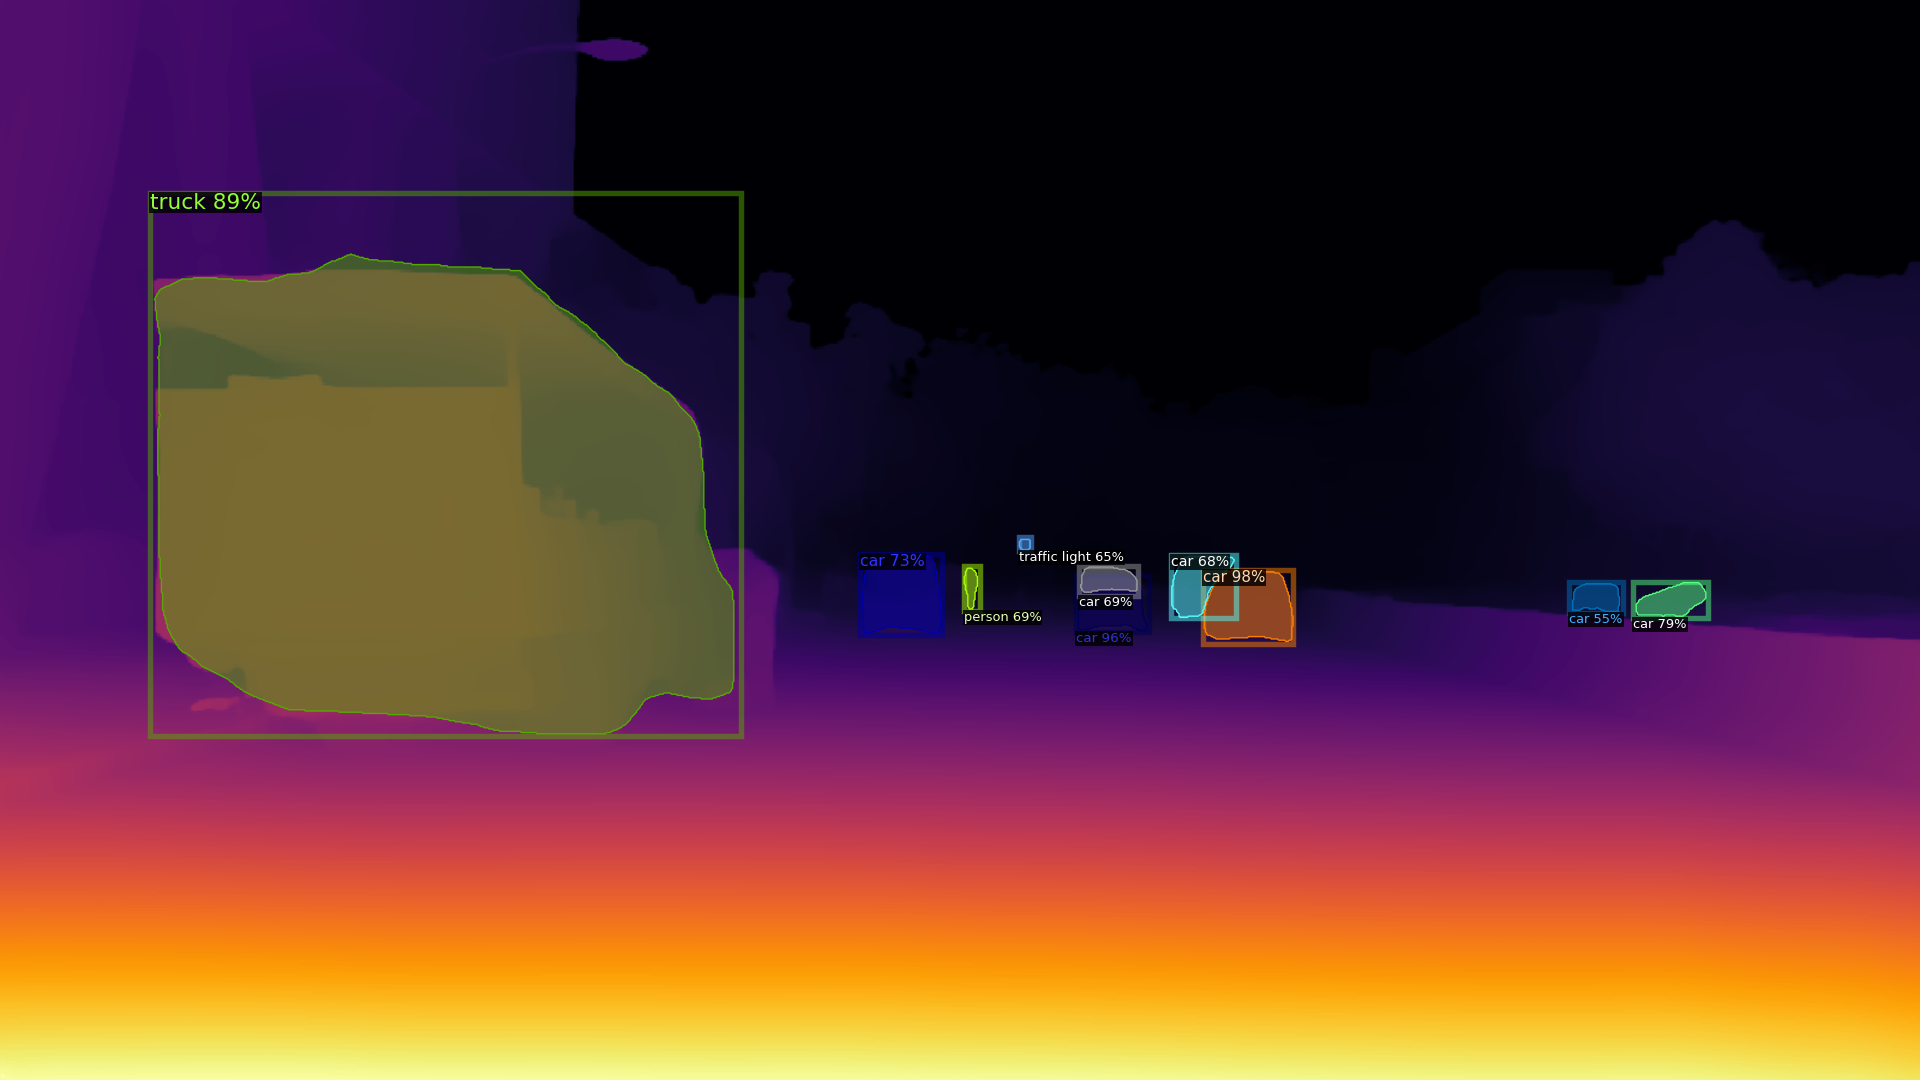

In [ ]:
#drawing bounding box on depth map
v = Visualizer(res_depth[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# print out median depths
masks = outputs["instances"].pred_masks if outputs["instances"].has("pred_masks") else None

median_depths = []
for i, mask in enumerate(masks):
    mask = mask.to("cpu").numpy()

    object_depth_values = res_depth[mask].flatten()

    object_depth_values = object_depth_values[object_depth_values > 0]

    if len(object_depth_values) > 0:
        median_depth = np.median(object_depth_values)
        median_depths.append(median_depth)
        print(f"Object {i} - Median Depth: {median_depth}")
    else:
        print(f"Object {i} has no valid depth values.")

Object 0 - Median Depth: 31.0
Object 1 - Median Depth: 28.0
Object 2 - Median Depth: 100.0
Object 3 - Median Depth: 22.0
Object 4 - Median Depth: 28.0
Object 5 - Median Depth: 17.0
Object 6 - Median Depth: 21.0
Object 7 - Median Depth: 11.0
Object 8 - Median Depth: 4.0
Object 9 - Median Depth: 17.0


In [ ]:
!pip install open3d plotly

In [ ]:
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud
from pyquaternion import Quaternion
import numpy as np

def get_camera_intrinsics(nusc, sample_data_token):
    calibrated_sensor = nusc.get('calibrated_sensor', nusc.get('sample_data', sample_data_token)['calibrated_sensor_token'])
    return np.array(calibrated_sensor['camera_intrinsic'])

def get_camera_extrinsics(nusc, sample_data_token):
    calibrated_sensor = nusc.get('calibrated_sensor', nusc.get('sample_data', sample_data_token)['calibrated_sensor_token'])

    rotation = np.array(calibrated_sensor['rotation'])
    translation = np.array(calibrated_sensor['translation'])

    rotation_matrix = Quaternion(rotation).rotation_matrix
    extrinsic_matrix = np.eye(4)
    extrinsic_matrix[:3, :3] = rotation_matrix
    extrinsic_matrix[:3, 3] = translation
    return extrinsic_matrix

In [ ]:
from scipy.ndimage import center_of_mass

def get_center_of_segmentation_mask(masks):
  centers = []
  for mask in masks:
    mask = mask.to("cpu").numpy()
    center = center_of_mass(mask)
    centers.append(center)
  return centers

In [ ]:
import plotly.graph_objects as go

def back_project_2d_to_3d(center_2d, depth, intrinsic_matrix):
    center_2d_homogeneous = np.array([center_2d[0], center_2d[1], 1.0])

    center_3d_camera = depth * np.linalg.inv(intrinsic_matrix).dot(center_2d_homogeneous)
    return center_3d_camera

def transform_to_world_coordinates(point_3d_camera, extrinsic_matrix):
    point_3d_camera_homogeneous = np.append(point_3d_camera, 1.0)

    point_3d_world = extrinsic_matrix.dot(point_3d_camera_homogeneous)
    return point_3d_world[:3]

import open3d as o3d

def create_point_cloud(points):
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    return point_cloud

def visualize_point_cloud(points):
    fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=5, color='blue', opacity=0.8)
    )])
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        width=800,
        height=800)
    fig.show()


In [ ]:
scene = nusc.scene[0]
first_sample_token = scene['first_sample_token']
first_sample = nusc.get('sample', first_sample_token)

sample_data_token = first_sample['data']['CAM_FRONT']

intrinsic = get_camera_intrinsics(nusc, sample_data_token)
extrinsic = get_camera_extrinsics(nusc, sample_data_token)

print("Intrinsic matrix (camera calibration):", intrinsic)
print("Extrinsic matrix (world to camera transformation):", extrinsic)

center_2d = get_center_of_segmentation_mask(masks)

center_3d_world_list = []

for i in range(0,len(center_2d)):
    center_3d_camera = back_project_2d_to_3d(center_2d[i], median_depths[i], intrinsic)
    center_3d_world = transform_to_world_coordinates(center_3d_camera, extrinsic)
    center_3d_world_list.append(center_3d_world)

points_3d = np.array(center_3d_world_list)

visualize_point_cloud(points_3d)

Intrinsic matrix (camera calibration): [[1.26641720e+03 0.00000000e+00 8.16267020e+02]
 [0.00000000e+00 1.26641720e+03 4.91507066e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Extrinsic matrix (world to camera transformation): [[ 5.68477868e-03 -5.63666773e-03  9.99967955e-01  1.70079119e+00]
 [-9.99983517e-01 -8.37115272e-04  5.68014846e-03  1.59456324e-02]
 [ 8.05071338e-04 -9.99983763e-01 -5.64133364e-03  1.51095764e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def convert_to_bev(points, grid_size, range_x, range_y):
    # Create an empty BEV grid
    bev_grid = np.zeros((grid_size[1], grid_size[0]))

    # Convert points to grid coordinates
    for point in points:
        x, y, z = point

        # Define grid resolution
        grid_x = int((x - range_x[0]) / (range_x[1] - range_x[0]) * grid_size[0])
        grid_y = int((y - range_y[0]) / (range_y[1] - range_y[0]) * grid_size[1])

        # Check bounds
        if 0 <= grid_x < grid_size[0] and 0 <= grid_y < grid_size[1]:
            # Accumulate height information or count points in the cell
            bev_grid[grid_y, grid_x] += 1  # Here we're counting the points

    return bev_grid

def visualize_bev(bev_grid):
    plt.imshow(bev_grid, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Point Count')
    plt.xlabel('X Grid Index')
    plt.ylabel('Y Grid Index')
    plt.title('Bird\'s Eye View')
    plt.show()

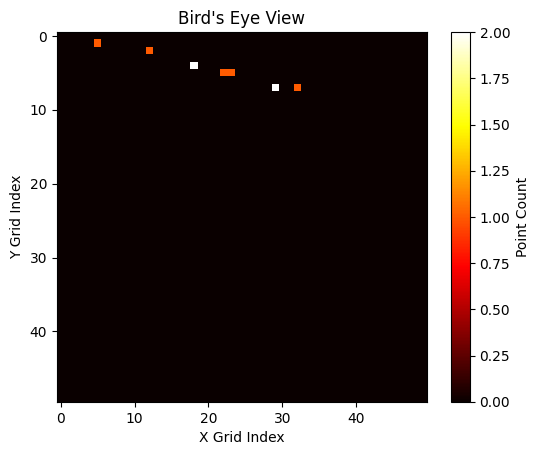

In [ ]:
grid_size = (50, 50)  # Size of the BEV grid (width, height)
range_x = (0, 50)        # X range of the grid
range_y = (0, 50)        # Y range of the grid

# Convert to BEV
bev_grid = convert_to_bev(points_3d, grid_size, range_x, range_y)

# Visualize BEV
visualize_bev(bev_grid)